# Classification multi-classe et stacking

On cherche à prédire la note d'un vin avec un classifieur multi-classe puis à améliorer le score obtenu avec une méthode dite de [stacking](https://www.quora.com/What-is-stacking-in-machine-learning).

## Le problème

Il n'est pas évident que les scores des différents modèles qu'on apprend sur chacun des classes soient comparables. Si le modèle n'est pas assez performant, on peut songer à ajouter un dernier modèle qui prend la décision finale en fonction du résultat de chaque modèle.

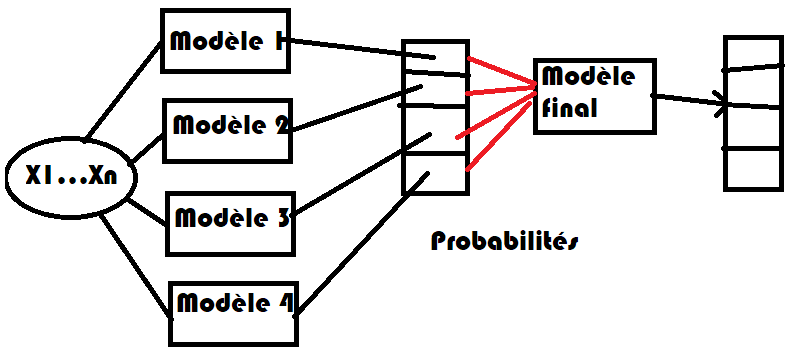

In [7]:
from IPython.display import Image

Image("images/stackmulti.png", width=400)

In [8]:
%matplotlib inline

In [9]:
from teachpyx.datasets import load_wines_dataset

df = load_wines_dataset()
X = df.drop(["quality", "color"], axis=1)
y = df["quality"]

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

clr = OneVsRestClassifier(LogisticRegression(max_iter=1500))
clr.fit(X_train, y_train)

,"estimator estimator: estimator objectA regressor or a classifier that implements :term:`fit`.When a classifier is passed, :term:`decision_function` will be usedin priority and it will fallback to :term:`predict_proba` if it is notavailable.When a regressor is passed, :term:`predict` is used.",LogisticRegre...max_iter=1500)
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation: the `n_classes`one-vs-rest problems are computed in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: 0.20 `n_jobs` default changed from 1 to None",None
,"verbose verbose: int, default=0The verbosity level, if non zero, progress messages are printed.Below 50, the output is sent to stderr. Otherwise, the output is sentto stdout. The frequency of the messages increases with the verbositylevel, reporting all iterations at 10. See :class:`joblib.Parallel` formore details... versionadded:: 1.1",0
,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=

In [12]:
import numpy

numpy.mean(clr.predict(X_test).ravel() == y_test.values.ravel()) * 100

np.float64(54.09230769230769)

On regarde la matrice de confusion.

In [13]:
from sklearn.metrics import confusion_matrix
import pandas

df = pandas.DataFrame(confusion_matrix(y_test, clr.predict(X_test)))
try:
    df.columns = [str(_) for _ in clr.classes_][: df.shape[1]]
    df.index = [str(_) for _ in clr.classes_][: df.shape[0]]
except ValueError:
    # Il peut arriver qu'une classe ne soit pas représenter
    # lors de l'apprentissage
    print("erreur", df.shape, clr.classes_)
df

,3,4,5,6,7,8,9
3,0,0,4,2,0,0,0
4,0,0,28,26,1,0,0
5,0,0,325,210,2,0,0
6,0,0,166,531,16,0,0
7,0,0,15,230,23,0,0
8,0,0,6,34,4,0,0
9,0,0,0,2,0,0,0


On cale d'abord une random forest sur les données brutes.

In [14]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
numpy.mean(rfc.predict(X_test).ravel() == y_test.values.ravel()) * 100

np.float64(67.6923076923077)

On cale une random forest avec les sorties de la régression logistique.

In [15]:
rf_train = clr.decision_function(X_train)

rfc_y = RandomForestClassifier()
rfc_y.fit(rf_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

On calcule le taux d'erreur.

In [16]:
rf_test = clr.decision_function(X_test)
numpy.mean(rfc_y.predict(rf_test).ravel() == y_test.values.ravel()) * 100

np.float64(65.72307692307693)

C'est presque équivalent à une random forest calée sur les données brutes. On trace les courbes ROC pour la classe 4.

In [17]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr_lr, tpr_lr, th_lr = roc_curve(y_test == 4, clr.decision_function(X_test)[:, 2])
fpr_rfc, tpr_rfc, th_rfc = roc_curve(y_test == 4, rfc.predict_proba(X_test)[:, 2])
fpr_rfc_y, tpr_rfc_y, th_rfc_y = roc_curve(
    y_test == 4, rfc_y.predict_proba(rf_test)[:, 2]
)
auc_lr = roc_auc_score(y_test == 4, clr.decision_function(X_test)[:, 2])
auc_rfc = roc_auc_score(y_test == 4, rfc.predict_proba(X_test)[:, 2])
auc_rfc_y = roc_auc_score(y_test == 4, rfc_y.predict_proba(rf_test)[:, 2])
auc_lr, auc_rfc, auc_rfc_y

(0.610804863925883, 0.6194730746960047, 0.585865662999421)

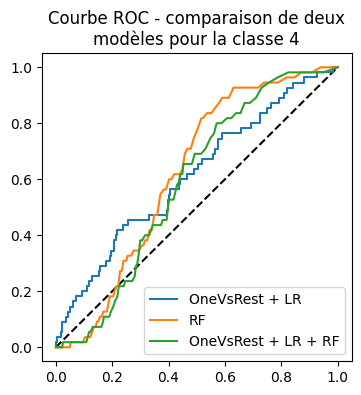

In [18]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot([0, 1], [0, 1], "k--")
ax.plot(fpr_lr, tpr_lr, label="OneVsRest + LR")
ax.plot(fpr_rfc, tpr_rfc, label="RF")
ax.plot(fpr_rfc_y, tpr_rfc_y, label="OneVsRest + LR + RF")
ax.set_title("Courbe ROC - comparaison de deux\nmodèles pour la classe 4")
ax.legend();

La courbe ROC ne montre rien de probant. Il faudrait vérifier avec une cross-validation qu'il serait pratique de faire avec un [pipeline](https://scikit-learn.org/stable/modules/pipeline.html) mais ceux-ci n'acceptent qu'un seul prédicteur final.

In [19]:
from sklearn.pipeline import make_pipeline

try:
    pipe = make_pipeline(
        OneVsRestClassifier(LogisticRegression(max_iter=1500)), RandomForestClassifier()
    )
except Exception as e:
    print("ERREUR :")
    print(e)

On construit une ROC sur toutes les classes.

In [20]:
fpr_lr, tpr_lr, th_lr = roc_curve(
    y_test == clr.predict(X_test),
    clr.predict_proba(X_test).max(axis=1),
    drop_intermediate=False,
)
fpr_rfc, tpr_rfc, th_rfc = roc_curve(
    y_test == rfc.predict(X_test),
    rfc.predict_proba(X_test).max(axis=1),
    drop_intermediate=False,
)
fpr_rfc_y, tpr_rfc_y, th_rfc_y = roc_curve(
    y_test == rfc_y.predict(rf_test),
    rfc_y.predict_proba(rf_test).max(axis=1),
    drop_intermediate=False,
)
auc_lr = roc_auc_score(
    y_test == clr.predict(X_test), clr.decision_function(X_test).max(axis=1)
)
auc_rfc = roc_auc_score(
    y_test == rfc.predict(X_test), rfc.predict_proba(X_test).max(axis=1)
)
auc_rfc_y = roc_auc_score(
    y_test == rfc_y.predict(rf_test), rfc_y.predict_proba(rf_test).max(axis=1)
)
auc_lr, auc_rfc, auc_rfc_y

(0.5566906703022872, 0.7535939393939393, 0.7387052091528319)

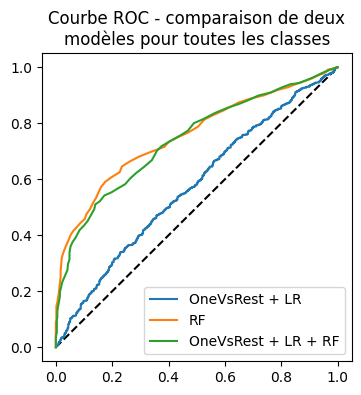

In [21]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot([0, 1], [0, 1], "k--")
ax.plot(fpr_lr, tpr_lr, label="OneVsRest + LR")
ax.plot(fpr_rfc, tpr_rfc, label="RF")
ax.plot(fpr_rfc_y, tpr_rfc_y, label="OneVsRest + LR + RF")
ax.set_title("Courbe ROC - comparaison de deux\nmodèles pour toutes les classes")
ax.legend();

Sur ce modèle, le score produit par le classifieur final paraît plus partinent que le score obtenu en prenant le score maximum sur toutes les classes. On tente une dernière approche où le modèle final doit valider ou non la réponse : c'est un classifieur binaire. Avec celui-ci, tous les classifieurs estimés sont binaires.

In [22]:
rf_train_bin = clr.decision_function(X_train)
y_train_bin = clr.predict(X_train) == y_train
rfc = RandomForestClassifier()
rfc.fit(rf_train_bin, y_train_bin)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

On regarde les premières réponses.

In [23]:
rf_test_bin = clr.decision_function(X_test)
rfc.predict_proba(rf_test_bin)[:3]

array([[0.26, 0.74],
       [0.76, 0.24],
       [0.66, 0.34]])

In [24]:
y_test_bin = clr.predict(X_test) == y_test

In [25]:
fpr_rfc_bin, tpr_rfc_bin, th_rfc_bin = roc_curve(
    y_test_bin, rfc.predict_proba(rf_test_bin)[:, 1]
)
auc_rfc_bin = roc_auc_score(y_test_bin, rfc.predict_proba(rf_test_bin)[:, 1])
auc_lr, auc_rfc_bin

(0.5566906703022872, 0.7760471471663816)

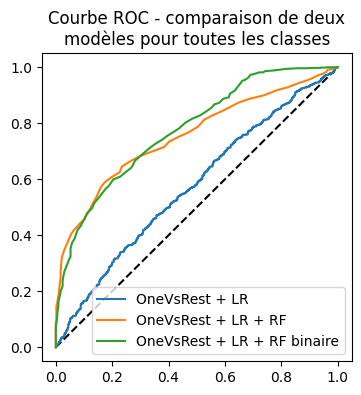

In [26]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot([0, 1], [0, 1], "k--")
ax.plot(fpr_lr, tpr_lr, label="OneVsRest + LR")
ax.plot(fpr_rfc, tpr_rfc, label="OneVsRest + LR + RF")
ax.plot(fpr_rfc_bin, tpr_rfc_bin, label="OneVsRest + LR + RF binaire")
ax.set_title("Courbe ROC - comparaison de deux\nmodèles pour toutes les classes")
ax.legend();

Un peu mieux mais il faudrait encore valider avec une validation croisée et plusieurs jeux de données, y compris artificiels. Il reste néanmoins l'idée.

## Automatisation avec une implémentation

Comme c'est fastidieux de faire tout cela, on crée un pipeline. *scikit-learn* a introduit le modèle [StackingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier).

In [27]:
from sklearn.ensemble import StackingClassifier

model = StackingClassifier(
    [
        ("ovrlr", LogisticRegression()),
        ("rf", RandomForestClassifier()),
    ]
)
model.fit(X_train, y_train)

/home/xadupre/vv/this312/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/xadupre/vv/this312/lib/python3.12/site-packages/sklearn/model_selection/_split.py:813: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/xadupre/vv/this312/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITER

,"estimators estimators: list of (str, estimator)Base estimators which will be stacked together. Each element of thelist is defined as a tuple of string (i.e. name) and an estimatorinstance. An estimator can be set to 'drop' using `set_params`.The type of estimator is generally expected to be a classifier.However, one can pass a regressor for some use case (e.g. ordinalregression).","[('ovrlr', ...), ('rf', ...)]"
,"final_estimator final_estimator: estimator, default=NoneA classifier which will be used to combine the base estimators.The default classifier is a:class:`~sklearn.linear_model.LogisticRegression`.",None
,"cv cv: int, cross-validation generator, iterable, or ""prefit"", default=NoneDetermines the cross-validation splitting strategy used in`cross_val_predict` to train `final_estimator`. Possible inputs forcv are:* None, to use the default 5-fold cross validation,* integer, to specify the number of folds in a (Stratified) KFold,* An object to be used as a cross-validation generator,* An iterable yielding train, test splits,* `""prefit""`, to assume the `estimators` are prefit. In this case, the estimators will not be refitted.For integer/None inputs, if the estimator is a classifier and y iseither binary or multiclass,:class:`~sklearn.model_selection.StratifiedKFold` is used.In all other cases, :class:`~sklearn.model_selection.KFold` is used.These splitters are instantiated with `shuffle=False` so the splitswill be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here.If ""prefit"" is passed, it is assumed that all `estimators` havebeen fitted already. The `final_estimator_` is trained on the `estimators`predictions on the full training set and are **not** cross validatedpredictions. Please note that if the models have been trained on the samedata to train the stacking model, there is a very high risk of overfitting... versionadded:: 1.1 The 'prefit' option was added in 1.1.. note:: A larger number of split will provide no benefits if the number of training samples is large enough. Indeed, the training time will increase. ``cv`` is not used for model evaluation but for prediction.",None
,"stack_method stack_method: {'auto', 'predict_proba', 'decision_function', 'predict'}, default='auto'Methods called for each base estimator. It can be:* if 'auto', it will try to invoke, for each estimator, `'predict_proba'`, `'decision_function'` or `'predict'` in that order.* otherwise, one of `'predict_proba'`, `'decision_function'` or `'predict'`. If the method is not implemented by the estimator, it will raise an error.",'auto'
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for `fit` of all `estimators`.`None` means 1 unless in a `joblib.parallel_backend` context. -1 meansusing all processors. See :term:`Glossary ` for more details.",None
,"passthrough passthrough: bool, default=FalseWhen False, only the predictions of estimators will be used astraining data for `final_estimator`. When True, the`final_estimator` is trained on the predictions as well as theoriginal training data.",False
,"verbose verbose: int, default=0Verbosity level.",0
,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularizatio

In [28]:
fpr_pipe, tpr_pipe, th_pipe = roc_curve(
    y_test == model.predict(X_test),
    model.predict_proba(X_test).max(axis=1),
    drop_intermediate=False,
)
auc_pipe = roc_auc_score(
    y_test == model.predict(X_test), model.predict_proba(X_test).max(axis=1)
)
auc_pipe

0.7486097777777779

La validation croisée a été escamotée par gain de temps mais faire l'impasse est risquée dans le cas général.